In [34]:
import typer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from rich.console import Console
from rich.pretty import Pretty

console = Console()


In [19]:
def printRange(something):
    console = Console()
    if len(something) > 100:
        console.print(Pretty(something[:100]))
        console.print(f"...and {len(something)-100} more elements.")
    else:
        console.print(Pretty(something))

In [20]:
def setUniqueNumberic(df, column, unique_values):
    if len(unique_values) == 2:
        df[column] = df[column].apply(lambda x: 0 if x == unique_values[0] else 1)
    else:
        df[column] = df[column].apply(lambda x: unique_values.tolist().index(x))

def testNumericAttributes(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            unique_values = df[column].unique()
            console.print(f"Column: {column} - Unique values: ")
            printRange(unique_values)
            if typer.confirm(f"Convert {column} to numeric?"):
                conversion_type = typer.prompt("\n-> Choose method: (u)nique or (s)tring)")
                if conversion_type == 'u':
                    setUniqueNumberic(df, column, unique_values)
                elif conversion_type == 's':
                    df[column] = pd.to_numeric(df[column], errors='coerce').astype('Float64')
                else:
                    console.print("Invalid conversion type. Please choose 'unique' or 'string.'\n")
            else:
                console.print("Column conversion cancelled.\n=")

In [21]:
df = pd.read_csv('../datos_homeloan.csv')

In [22]:
df.drop(['Loan_ID'], axis=1, inplace=True)
df.drop(['Gender'], axis=1, inplace=True)

In [ ]:
testNumericAttributes(df)

In [26]:
imputer = KNNImputer(n_neighbors=5, weights="distance", metric="nan_euclidean")
imputer.fit(df)
df_imputed = pd.DataFrame(imputer.transform(df), columns=df.columns)

In [50]:
print(df_imputed)

     Married  Dependents  Education  SelfEmployed  ApplicantIncome  \
0        0.0         0.0        0.0           0.0           5849.0   
1        1.0         1.0        0.0           0.0           4583.0   
2        1.0         0.0        0.0           1.0           3000.0   
3        1.0         0.0        1.0           0.0           2583.0   
4        0.0         0.0        0.0           0.0           6000.0   
..       ...         ...        ...           ...              ...   
609      0.0         0.0        0.0           0.0           2900.0   
610      1.0         3.0        0.0           0.0           4106.0   
611      1.0         1.0        0.0           0.0           8072.0   
612      1.0         2.0        0.0           0.0           7583.0   
613      0.0         0.0        0.0           1.0           4583.0   

     CoapplicantIncome  LoanAmount  LoanAmountTerm  PropertyArea  LoanStatus  
0                  0.0  144.178808           360.0           0.0         0.0  
1

In [51]:
dbscan_model = DBSCAN(eps=500, min_samples=5)
dbscan_model.fit(df_imputed)

DBSCAN(eps=500)

In [52]:
outlier_indices = np.where(dbscan_model.labels_ == -1)[0]

In [53]:
outliers = df_imputed.iloc[outlier_indices]
print(outliers.describe())

         Married  Dependents  Education  SelfEmployed  ApplicantIncome  \
count  90.000000   90.000000  90.000000     90.000000        90.000000   
mean    0.733333    0.977778   0.077778      0.322222     11831.955556   
std     0.444694    1.151236   0.269322      0.557438     13339.020441   
min     0.000000    0.000000   0.000000      0.000000       150.000000   
25%     0.000000    0.000000   0.000000      0.000000      4012.500000   
50%     1.000000    1.000000   0.000000      0.000000      8014.000000   
75%     1.000000    2.000000   0.000000      1.000000     16217.500000   
max     1.000000    4.000000   1.000000      2.000000     81000.000000   

       CoapplicantIncome  LoanAmount  LoanAmountTerm  PropertyArea  LoanStatus  
count          90.000000   90.000000       90.000000     90.000000   90.000000  
mean         4340.822222  247.489665      339.142981      1.066667    0.333333  
std          6354.648642  149.091304       65.543718      0.804482    0.474045  
min      

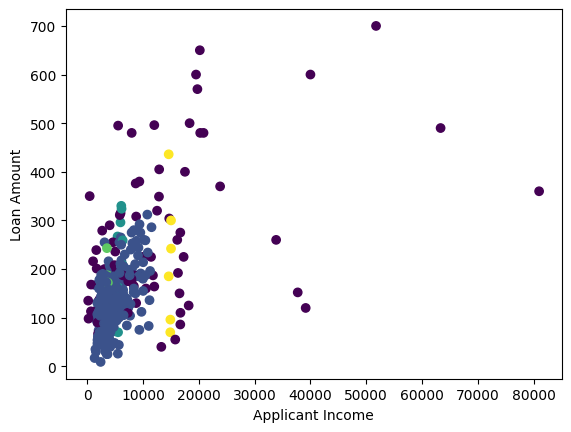

In [49]:
labels = dbscan_model.labels_
df['cluster'] = labels
plt.scatter(df['ApplicantIncome'], df['LoanAmount'], c=df['cluster'])
plt.xlabel('Applicant Income')
plt.ylabel('Loan Amount')
plt.show()

Esto muestra que los datos tienen una distribucion sesgada hacia valores mas altos (obviamente), probeblamente
sea recomendable tener que normalizar los valores para sacar rentabilidad al boxplot

[Text(1, 0, 'Applicant Income')]

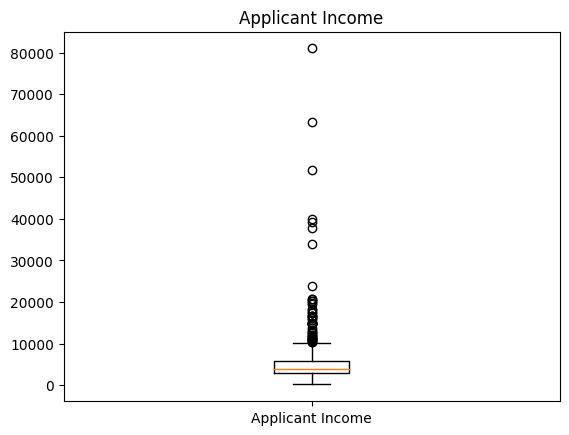

In [57]:
fix, ax = plt.subplots()
ax.boxplot(df_imputed['ApplicantIncome'].values)
ax.set_title('Applicant Income')
ax.set_xticklabels(['Applicant Income'])

[Text(1, 0, 'LoanStatus')]

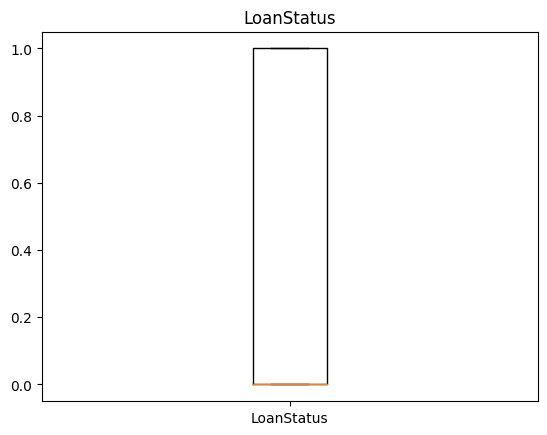

In [63]:
fix, ax = plt.subplots()
ax.boxplot(df_imputed['LoanStatus'].values)
ax.set_title('LoanStatus')
ax.set_xticklabels(['LoanStatus'])

Otra forma de hacerlo es haciendo un análisis de rango intercuartil (IQR)

In [68]:
# Calcular límites superior e inferior
mean = np.mean(df_imputed['LoanStatus'])
std = np.std(df_imputed['LoanStatus'])
limite_superior = mean + 3*std
limite_inferior = mean - 3*std

# Seleccionar filas con valores por encima o por debajo de los límites
outliers = df_imputed.loc[(df_imputed['LoanStatus'] > limite_superior) | (df_imputed['LoanStatus'] < limite_inferior)]

# Imprimir outliers
print(outliers)

Empty DataFrame
Columns: [Married, Dependents, Education, SelfEmployed, ApplicantIncome, CoapplicantIncome, LoanAmount, LoanAmountTerm, PropertyArea, LoanStatus]
Index: []
